# 0. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import TomekLinks
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import multiprocessing as mp
import pickle

# 1. EDA Pipeline

In [29]:
def amount_descriptive_stats(data, column='transaction_type'):
    if column in ['transaction_type', 'channel']: 
        df = pd.DataFrame([])
        for trans in data['transaction_type'].unique():
            df = df.append(data[data['transaction_type']==trans]['amount'].describe().rename(trans))

        df = df.T
        return df
    else: 
        raise ValueError(f'Column: \'{column}\' not supported') 

In [47]:
def percentages(data,strin, plot=True):
    
    # Plot pie chart
    if plot:
        plt.figure(figsize=(5,5))
        data['flag'].value_counts().plot(kind='pie')
        plt.title(strin)
        plt.show()
    
    #Percentages
    print(f'Percentage of {data.flag.value_counts().index[0]}: {100*data.flag.value_counts()[0]/sum(data.flag.value_counts())}')
    print(f'Percentage of {data.flag.value_counts().index[1]}: {100*data.flag.value_counts()[1]/sum(data.flag.value_counts())}')

In [31]:
def exploratory_visualization(data, column='transaction_type', plt_type='bar'):
    
    if column in ['transaction_type', 'channel']: 
        if plt_type=='bar':
            plt.figure(figsize=(15,15))
            i=0
            for trans in data[column].unique():
                i+=1
                ax = plt.subplot(5, 5, i)
                plt.boxplot(data[data[column]==trans]['amount'])
                plt.title(trans)
            plt.tight_layout(h_pad=1 , w_pad=1.5)
            #plt.suptitle('Boxplots of amount per transaction type',  fontsize=25)
            plt.show()
        elif plt_type=='hist':
            plt.figure(figsize=(15,15))
            i=0
            for trans in data[column].unique():
                i+=1
                ax = plt.subplot(5, 5, i)
                plt.hist(data[data[column]==trans]['amount'])
                plt.title(trans)
            plt.tight_layout(h_pad=1 , w_pad=1.5)
            #plt.suptitle('Boxplots of amount per transaction type',  fontsize=25)
            plt.show()
        else:
            raise ValueError(f'Plot type: \'{plt_type}\' not supported')       
    else: 
        raise ValueError(f'Column: \'{column}\' not supported') 

In [52]:
def transactions_type(data, strin, plot=True):
    if plot:
        data['channel'].value_counts().plot(kind='barh')
        plt.title('Number of transtactions per type'+strin)
        plt.show()
        
    return data['channel'].value_counts()

# Read data

In [2]:
transactions = [pd.read_csv('sim4.csv', delimiter=';'), pd.read_csv('sim5.csv', delimiter=';'),pd.read_csv('sim1.csv', delimiter=',')]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Explore data

In [22]:
transactions[2].info(),transactions[1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143216 entries, 0 to 143215
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   account_from      143216 non-null  object 
 1   account_to        143216 non-null  object 
 2   sender            143216 non-null  object 
 3   receiver          143216 non-null  object 
 4   amount            143216 non-null  float64
 5   channel           143216 non-null  object 
 6   currency          143216 non-null  object 
 7   date              143216 non-null  object 
 8   flag              143216 non-null  object 
 9   location          143216 non-null  object 
 10  transaction_type  143216 non-null  object 
 11  transaction_id    143216 non-null  int64  
dtypes: float64(1), int64(1), object(10)
memory usage: 13.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26092 entries, 0 to 26091
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype

(None, None)

In [16]:
transactions[2].head()

,account_from,account_to,sender,receiver,amount,channel,currency,date,flag,location,transaction_type,transaction_id
0,Account 813,Account 732,Businesses 82,Fraudulent_businesses 1,40348.63,Paym,GBP,2021-01-01 09:03:22,transaction,UK,2.2,423993
1,Account 813,Account 824,Businesses 82,Businesses 93,118974.40,LINK,GBP,2021-01-01 09:03:22,transaction,UK,2.2,423994
2,Account 813,Account 765,Businesses 82,Businesses 34,385.53,C&CCC,GBP,2021-01-01 09:03:22,transaction,UK,0.1,423995
3,Account 865,Account 910,Individuals 34,Individuals 79,5.77,FPS,GBP,2021-01-01 09:03:22,transaction,UK,0.2,423996
4,Account 865,Account 910,Individuals 34,Individuals 79,127.90,C&CCC,GBP,2021-01-01 09:03:22,transaction,UK,0.2,423997


In [23]:
len(transactions[2]['channel'].unique())

7

In [25]:
transactions[2].tail()

,account_from,account_to,sender,receiver,amount,channel,currency,date,flag,location,transaction_type,transaction_id
143211,Account 781,Account 809,Businesses 50,Businesses 78,782.81,C&CCC,GBP,2021-12-31 09:03:22,transaction,UK,0.1,567204
143212,Account 781,Account 809,Businesses 50,Businesses 78,837.19,CHAPS,GBP,2021-12-31 09:03:22,transaction,UK,0.1,567205
143213,Account 928,Account 925,Individuals 97,Individuals 94,19.32,Bacs,GBP,2021-12-31 09:03:22,transaction,UK,0.2,567206
143214,Account 829,Account 881,Businesses 98,Individuals 50,11149.17,C&CCC,GBP,2021-12-31 09:03:22,transaction,UK,5.0,567207
143215,Account 829,Account 736,Businesses 98,Fraudulent_businesses 5,2187.11,Paym,GBP,2021-12-31 09:03:22,transaction,UK,0.1,567208


In [26]:
transactions[2].columns

Index(['account_from', 'account_to', 'sender', 'receiver', 'amount', 'channel',
       'currency', 'date', 'flag', 'location', 'transaction_type',
       'transaction_id'],
      dtype='object')

In [27]:
transactions[2].shape

(143216, 12)

In [33]:
amount_descriptive_stats(transactions[2])

,2.2,0.1,0.2,5.0,bribe,1.2,3.3,pay false service,4.2,travel expenses payment,kickback payment,3.2,1.1,3.1,4.1,cashout
25%,2.879229e+04,331.900000,12.292500,1293.662500,2000.0,242.000000,245.745000,20000.0,3.226470e+04,581.565000,88.445000,4245.470000,229.330000,224.230000,8589.010000,120000.0
50%,5.659984e+04,730.130000,32.630000,1756.795000,2000.0,353.840000,362.200000,20000.0,7.084016e+04,651.180000,99.330000,8547.770000,319.400000,316.180000,49999.920000,120000.0
75%,1.111025e+05,1378.865000,54.700000,2596.682500,2000.0,651.350000,620.355000,20000.0,2.119775e+05,752.670000,114.145000,13984.270000,402.790000,397.540000,50000.000000,120000.0
count,1.285000e+03,94843.000000,28954.000000,9852.000000,10.0,2419.000000,2327.000000,70.0,3.100000e+01,175.000000,175.000000,103.000000,1485.000000,1405.000000,72.000000,10.0
max,1.866340e+06,8686.540000,440.640000,12128.620000,2000.0,14926.930000,14862.720000,20000.0,1.223964e+06,987.090000,147.060000,50457.410000,24266.510000,528.670000,50000.000000,120000.0
mean,1.494860e+05,1005.824241,43.642797,2233.456472,2000.0,1266.204634,1268.670563,20000.0,2.395973e+05,667.364457,100.563200,10793.493786,844.529603,303.929772,31369.159861,120000.0
min,4.745460e+03,0.750000,0.040000,739.280000,2000.0,54.660000,54.100000,20000.0,9.599230e+03,423.460000,58.640000,222.340000,34.760000,19.420000,8588.990000,120000.0
std,2.596647e+05,931.930007,46.859807,1549.266275,0.0,2426.026140,2421.670415,0.0,3.582834e+05,122.069221,19.903863,9294.586581,2781.504656,116.746894,20606.541486,0.0


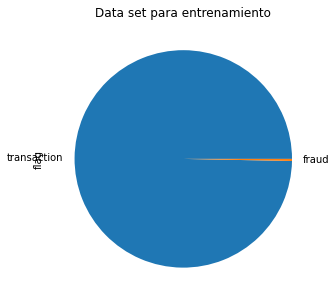

Percentage of transaction: 99.69277175734555
Percentage of fraud: 0.30722824265445203


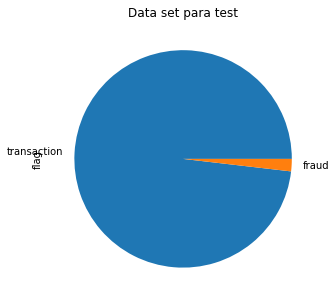

Percentage of transaction: 98.1642579860624
Percentage of fraud: 1.8357420139376082


In [48]:

percentages(transactions[2],"Data set para entrenamiento")
percentages(transactions[0],"Data set para test")

In [35]:
transactions[2][transactions[2]['transaction_type']=='bribe']['amount']

46     2000.0
131    2000.0
157    2000.0
163    2000.0
171    2000.0
178    2000.0
262    2000.0
331    2000.0
362    2000.0
388    2000.0
Name: amount, dtype: float64

Data set para entrenamiento


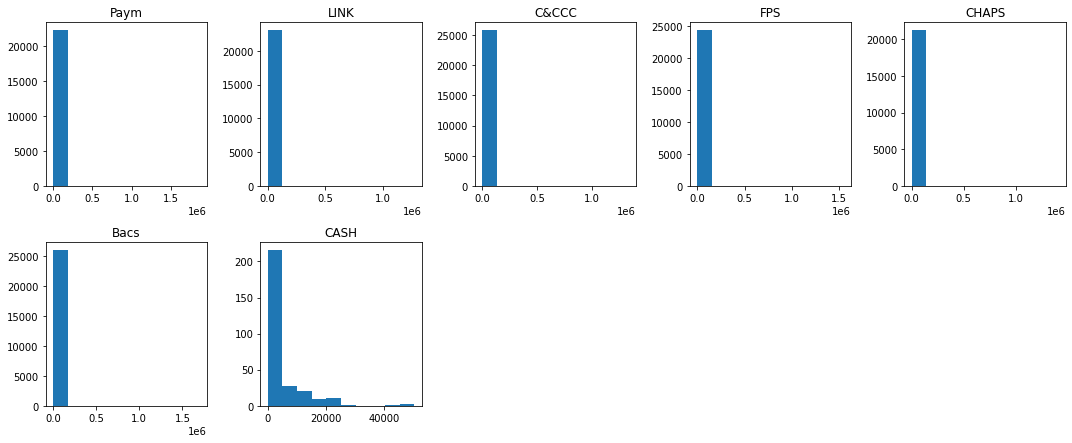

Data set para prueba


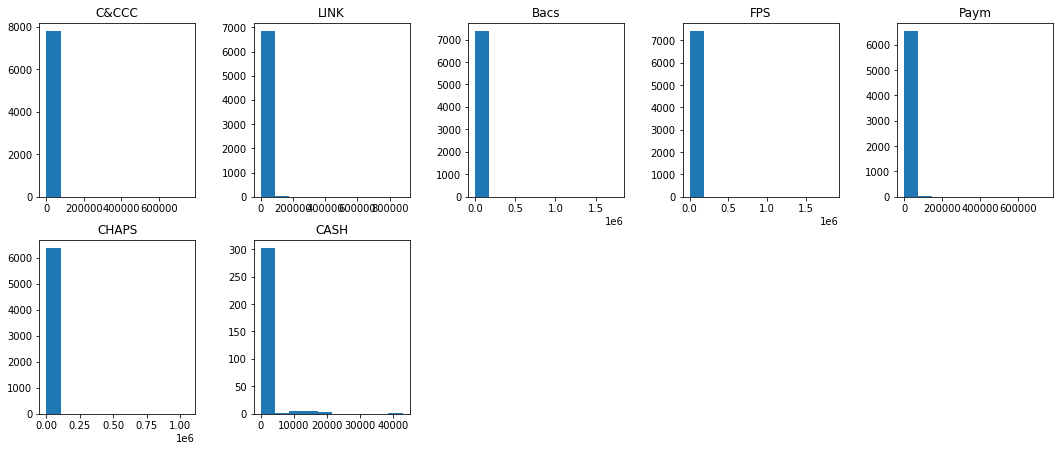

In [40]:
print("Data set para entrenamiento")
exploratory_visualization(transactions[2], column='channel' ,plt_type='hist')
print("Data set para prueba")
exploratory_visualization(transactions[0], column='channel' ,plt_type='hist')

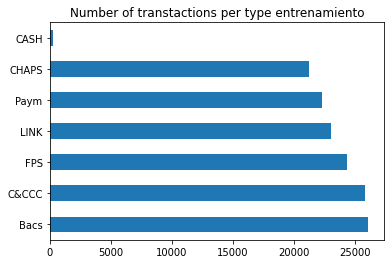

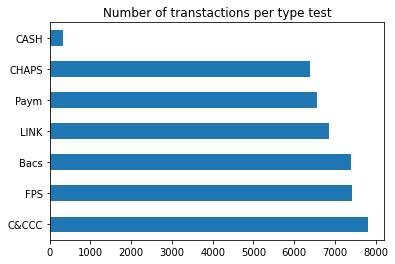

C&CCC    7821
FPS      7424
Bacs     7389
LINK     6866
Paym     6564
CHAPS    6378
CASH      320
Name: channel, dtype: int64

In [53]:
transactions_type(transactions[2],' entrenamiento', plot=True)
transactions_type(transactions[0],' test', plot=True)

# One hot encoding

In [57]:
def float_to_string(x):
    if type(x) == float:
        return str(x)
    else:
        return x

In [58]:
transactions[2]['transaction_type'] = transactions[2]['transaction_type'].apply(lambda x: float_to_string(x))

In [59]:
transactions_one_hot = [pd.get_dummies(data, columns=['channel', 'transaction_type']) for data in transactions]

In [60]:
transactions[1].head()

,account_from,account_to,sender,receiver,amount,channel,currency,date,flag,location,transaction_type,transaction_id
0,Account 617,Account 618,Fraudulent_businesses 8,Fraudulent_businesses 9,999.75,LINK,GBP,1/01/2021 9:03,transaction,UK,0.1,198163
1,Account 617,Account 618,Fraudulent_businesses 8,Fraudulent_businesses 9,618.67,FPS,GBP,1/01/2021 9:03,transaction,UK,0.1,198164
2,Account 617,Account 618,Fraudulent_businesses 8,Fraudulent_businesses 9,95.13,FPS,GBP,1/01/2021 9:03,transaction,UK,0.1,198165
3,Account 617,Account 618,Fraudulent_businesses 8,Fraudulent_businesses 9,808.09,LINK,GBP,1/01/2021 9:03,transaction,UK,0.1,198166
4,Account 617,Account 618,Fraudulent_businesses 8,Fraudulent_businesses 9,442.39,LINK,GBP,1/01/2021 9:03,transaction,UK,0.1,198167


In [61]:
transactions_one_hot[0].head()

,account_from,account_to,sender,receiver,amount,currency,date,flag,location,transaction_id,channel_Bacs,channel_C&CCC,channel_CASH,channel_CHAPS,channel_FPS,channel_LINK,channel_Paym,transaction_type_0.1,transaction_type_0.2,transaction_type_1.1,transaction_type_1.2,transaction_type_2.2,transaction_type_3.1,transaction_type_3.2,transaction_type_3.3,transaction_type_4.1,transaction_type_4.2,transaction_type_5,transaction_type_bribe,transaction_type_cashout,transaction_type_kickback payment,transaction_type_pay false service,transaction_type_travel expenses payment
0,Account 508,Account 584,Fraudulent_businesses 14,Fraudulent_individuals 21,20000.00,GBP,1/01/2021 9:03,fraud,UK,155401,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,Account 511,Account 585,Businesses 17,Fraudulent_individuals 18,20000.00,GBP,1/01/2021 9:03,fraud,UK,155402,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,Account 578,Account 562,Individuals 64,Individuals 48,36.80,GBP,1/01/2021 9:03,transaction,UK,155403,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Account 578,Account 562,Individuals 64,Individuals 48,48.66,GBP,1/01/2021 9:03,transaction,UK,155404,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Account 578,Account 562,Individuals 64,Individuals 48,100.31,GBP,1/01/2021 9:03,transaction,UK,155405,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [62]:
transactions[0].shape, transactions_one_hot[0].shape

((42762, 12), (42762, 33))

# Correlation

In [64]:
transactions_one_hot[2].corr()

,amount,transaction_id,channel_Bacs,channel_C&CCC,channel_CASH,channel_CHAPS,channel_FPS,channel_LINK,channel_Paym,transaction_type_0.1,transaction_type_0.2,transaction_type_1.1,transaction_type_1.2,transaction_type_2.2,transaction_type_3.1,transaction_type_3.2,transaction_type_3.3,transaction_type_4.1,transaction_type_4.2,transaction_type_5.0,transaction_type_bribe,transaction_type_cashout,transaction_type_kickback payment,transaction_type_pay false service,transaction_type_travel expenses payment
amount,1.000000,-0.038056,0.008063,-0.009251,0.002586,0.001806,-0.002798,-0.004374,0.006464,-0.063287,-0.039433,-0.005195,-0.004749,0.482269,-0.006905,0.007831,-0.004645,0.022439,0.120242,-0.000793,-0.000092,0.033868,-0.002671,0.013466,-0.001989
transaction_id,-0.038056,1.000000,0.020307,-0.013896,-0.024252,-0.007142,-0.014924,0.003912,0.014602,-0.008513,0.015951,0.050731,0.004240,-0.060594,0.048490,-0.013481,0.002040,-0.011133,-0.017317,-0.018665,-0.014429,0.000730,-0.017304,-0.021514,-0.017305
channel_Bacs,0.008063,0.020307,1.000000,-0.221376,-0.021200,-0.197174,-0.213876,-0.207018,-0.202822,-0.008143,-0.027891,-0.007288,-0.003812,0.004343,0.210755,-0.012670,-0.016932,0.008768,0.017634,-0.008842,-0.003947,-0.001783,-0.016519,-0.000627,0.000044
channel_C&CCC,-0.009251,-0.013896,-0.221376,1.000000,-0.021041,-0.195690,-0.212267,-0.205461,-0.201297,0.027184,-0.006722,0.000628,0.015123,-0.012230,-0.046656,-0.012575,-0.017126,-0.005649,-0.003192,-0.012396,-0.003917,0.002606,-0.016395,-0.004611,0.002328
channel_CASH,0.002586,-0.024252,-0.021200,-0.021041,1.000000,-0.018741,-0.020328,-0.019676,-0.019277,-0.062855,-0.022596,-0.004595,-0.005884,-0.004271,-0.004468,0.597643,-0.005769,-0.001007,-0.000660,-0.012201,0.186158,-0.000375,0.779204,-0.000993,-0.001570
channel_CHAPS,0.001806,-0.007142,-0.197174,-0.195690,-0.018741,1.000000,-0.189061,-0.182999,-0.179289,-0.013878,0.026870,0.038309,-0.022411,0.007555,-0.041555,-0.011200,-0.024294,-0.008487,-0.002138,0.012005,-0.003489,-0.003489,-0.014603,-0.009232,-0.014603
channel_FPS,-0.002798,-0.014924,-0.213876,-0.212267,-0.020328,-0.189061,1.000000,-0.198500,-0.194477,0.016342,-0.003530,-0.022142,0.025716,-0.005848,-0.045075,-0.012149,-0.009553,-0.010156,-0.001611,-0.000923,-0.003784,0.000663,-0.015840,0.005118,0.002776
channel_LINK,-0.004374,0.003912,-0.207018,-0.205461,-0.019676,-0.182999,-0.198500,1.000000,-0.188241,-0.016493,0.011987,-0.002313,-0.006023,0.001590,-0.043630,-0.011759,0.064432,0.018126,-0.005159,0.000687,-0.003663,0.000883,-0.015332,0.011786,0.003150
channel_Paym,0.006464,0.014602,-0.202822,-0.201297,-0.019277,-0.179289,-0.194477,-0.188241,1.000000,0.001022,0.004776,-0.004606,-0.009813,0.005905,-0.042746,-0.011521,0.005280,-0.002759,-0.006319,0.012551,-0.003589,0.001021,-0.015021,-0.002526,0.005926
transaction_type_0.1,-0.063287,-0.008513,-0.008143,0.027184,-0.062855,-0.013878,0.016342,-0.016493,0.001022,1.000000,-0.704863,-0.143328,-0.183536,-0.133234,-0.139375,-0.037565,-0.179954,-0.031404,-0.020603,-0.380578,-0.011701,-0.011701,-0.048977,-0.030964,-0.048977


In [66]:
transactions_one_hot[2].columns

Index(['account_from', 'account_to', 'sender', 'receiver', 'amount',
       'currency', 'date', 'flag', 'location', 'transaction_id',
       'channel_Bacs', 'channel_C&CCC', 'channel_CASH', 'channel_CHAPS',
       'channel_FPS', 'channel_LINK', 'channel_Paym', 'transaction_type_0.1',
       'transaction_type_0.2', 'transaction_type_1.1', 'transaction_type_1.2',
       'transaction_type_2.2', 'transaction_type_3.1', 'transaction_type_3.2',
       'transaction_type_3.3', 'transaction_type_4.1', 'transaction_type_4.2',
       'transaction_type_5.0', 'transaction_type_bribe',
       'transaction_type_cashout', 'transaction_type_kickback payment',
       'transaction_type_pay false service',
       'transaction_type_travel expenses payment'],
      dtype='object')

In [65]:
transactions[2].channel.unique()

array(['Paym', 'LINK', 'C&CCC', 'FPS', 'CHAPS', 'Bacs', 'CASH'],
      dtype=object)

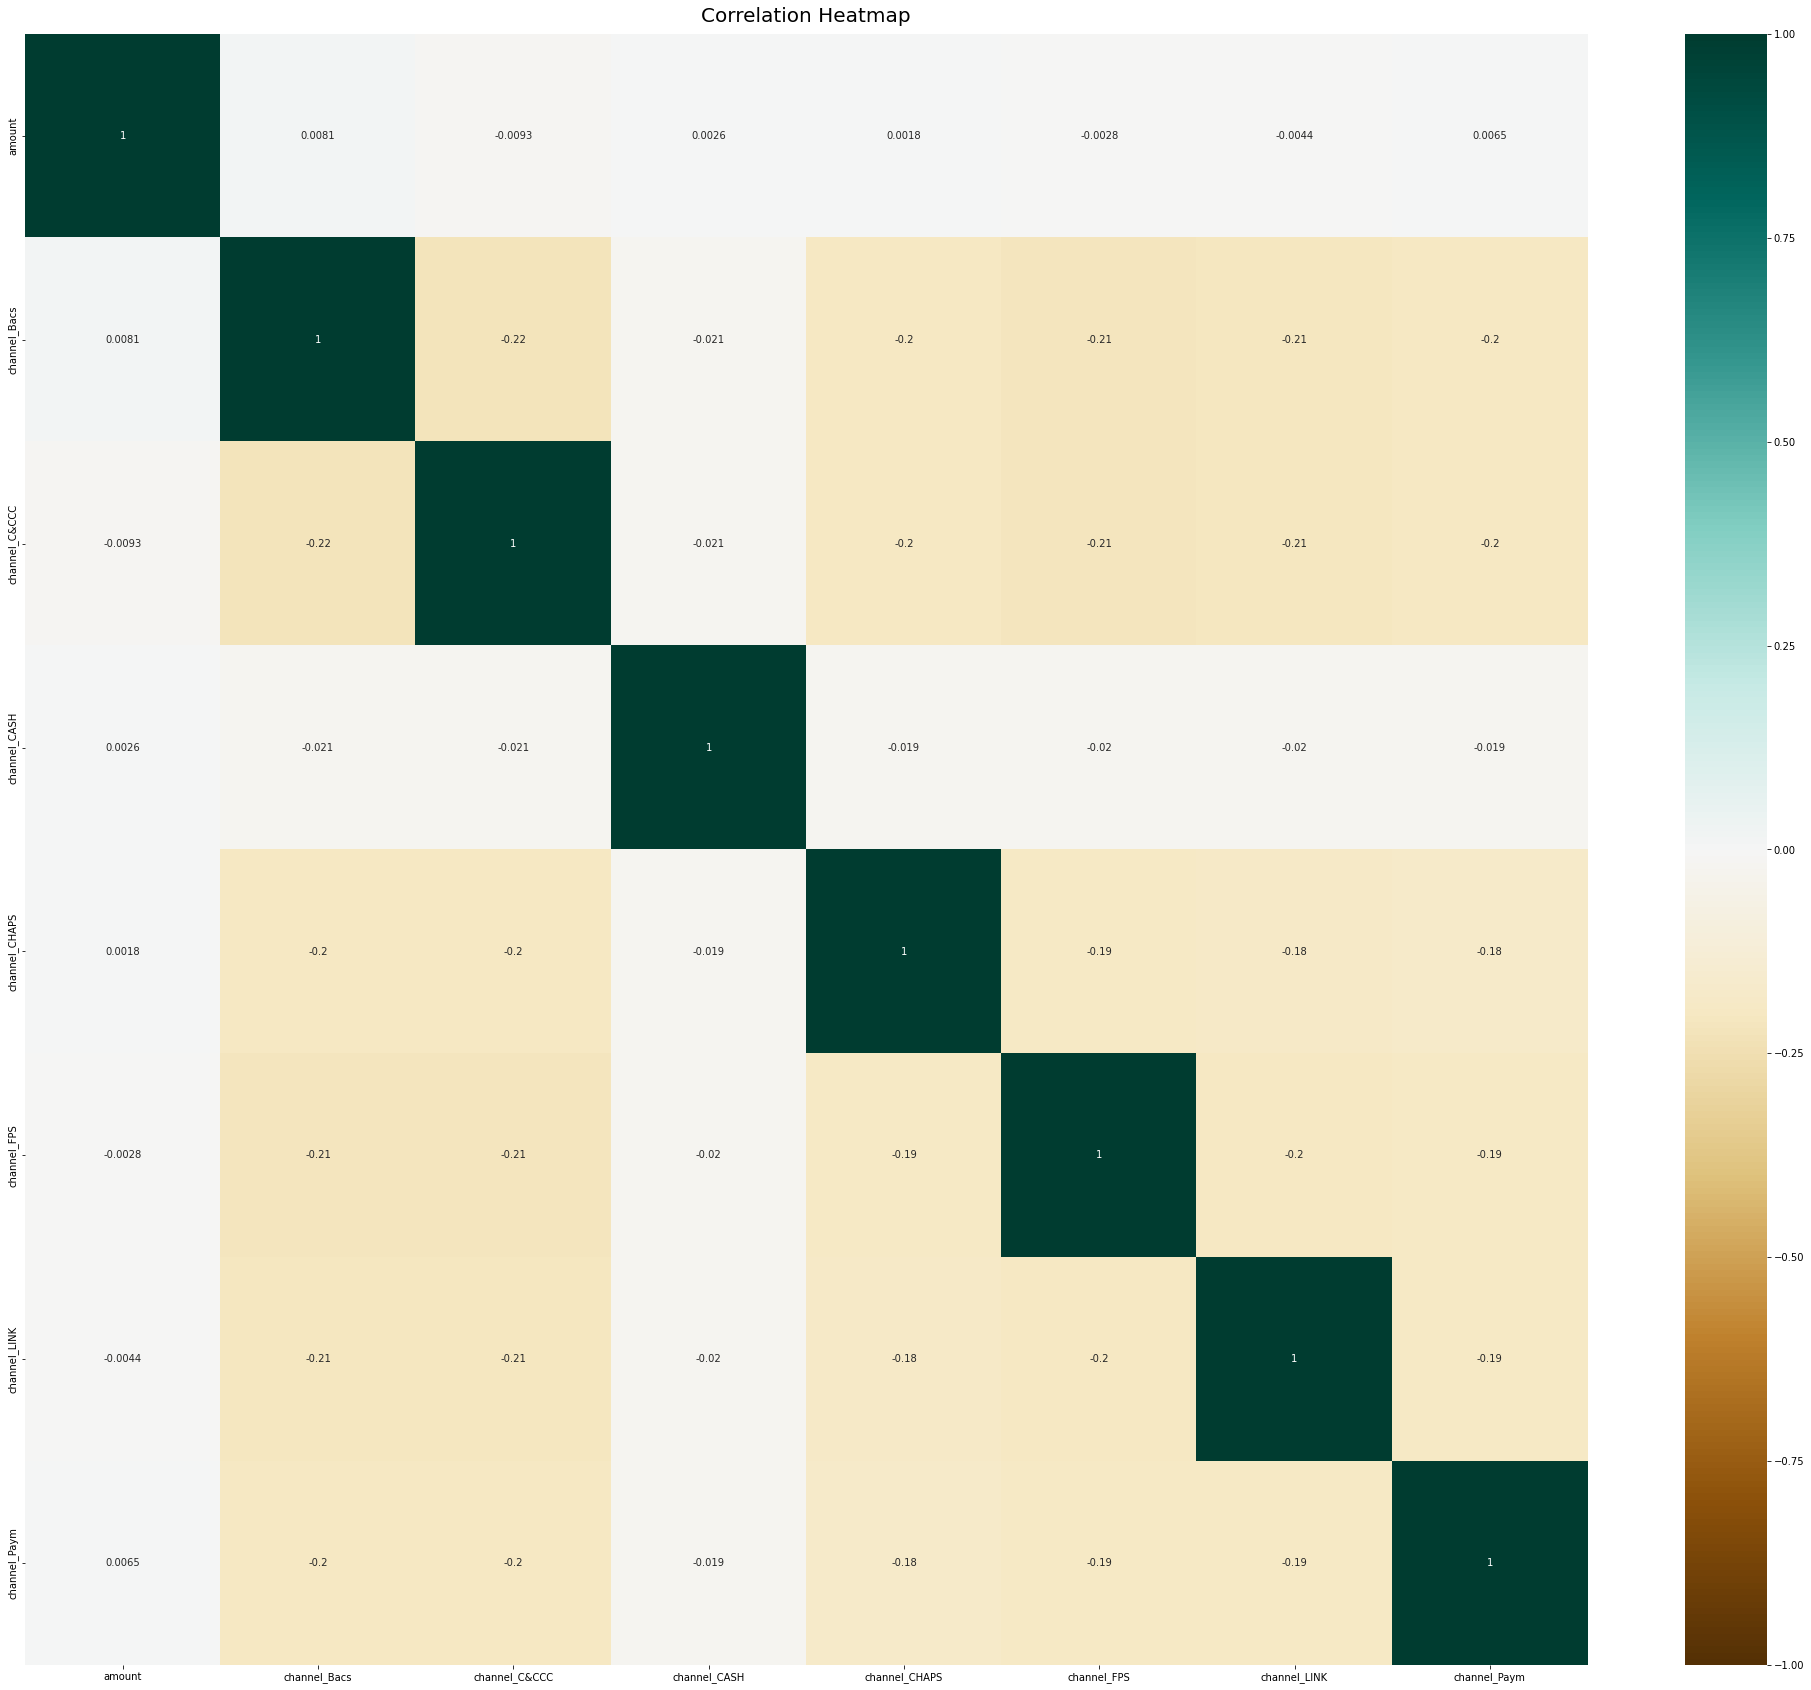

In [67]:
# Veamos la correlacion con un mapa de calor
corr_data = transactions_one_hot[2][['amount', 'channel_Bacs', 'channel_C&CCC', 'channel_CASH', 'channel_CHAPS',
                                 'channel_FPS', 'channel_LINK', 'channel_Paym']]
plt.figure(figsize=(35, 30))
heatmap = sns.heatmap(corr_data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12);

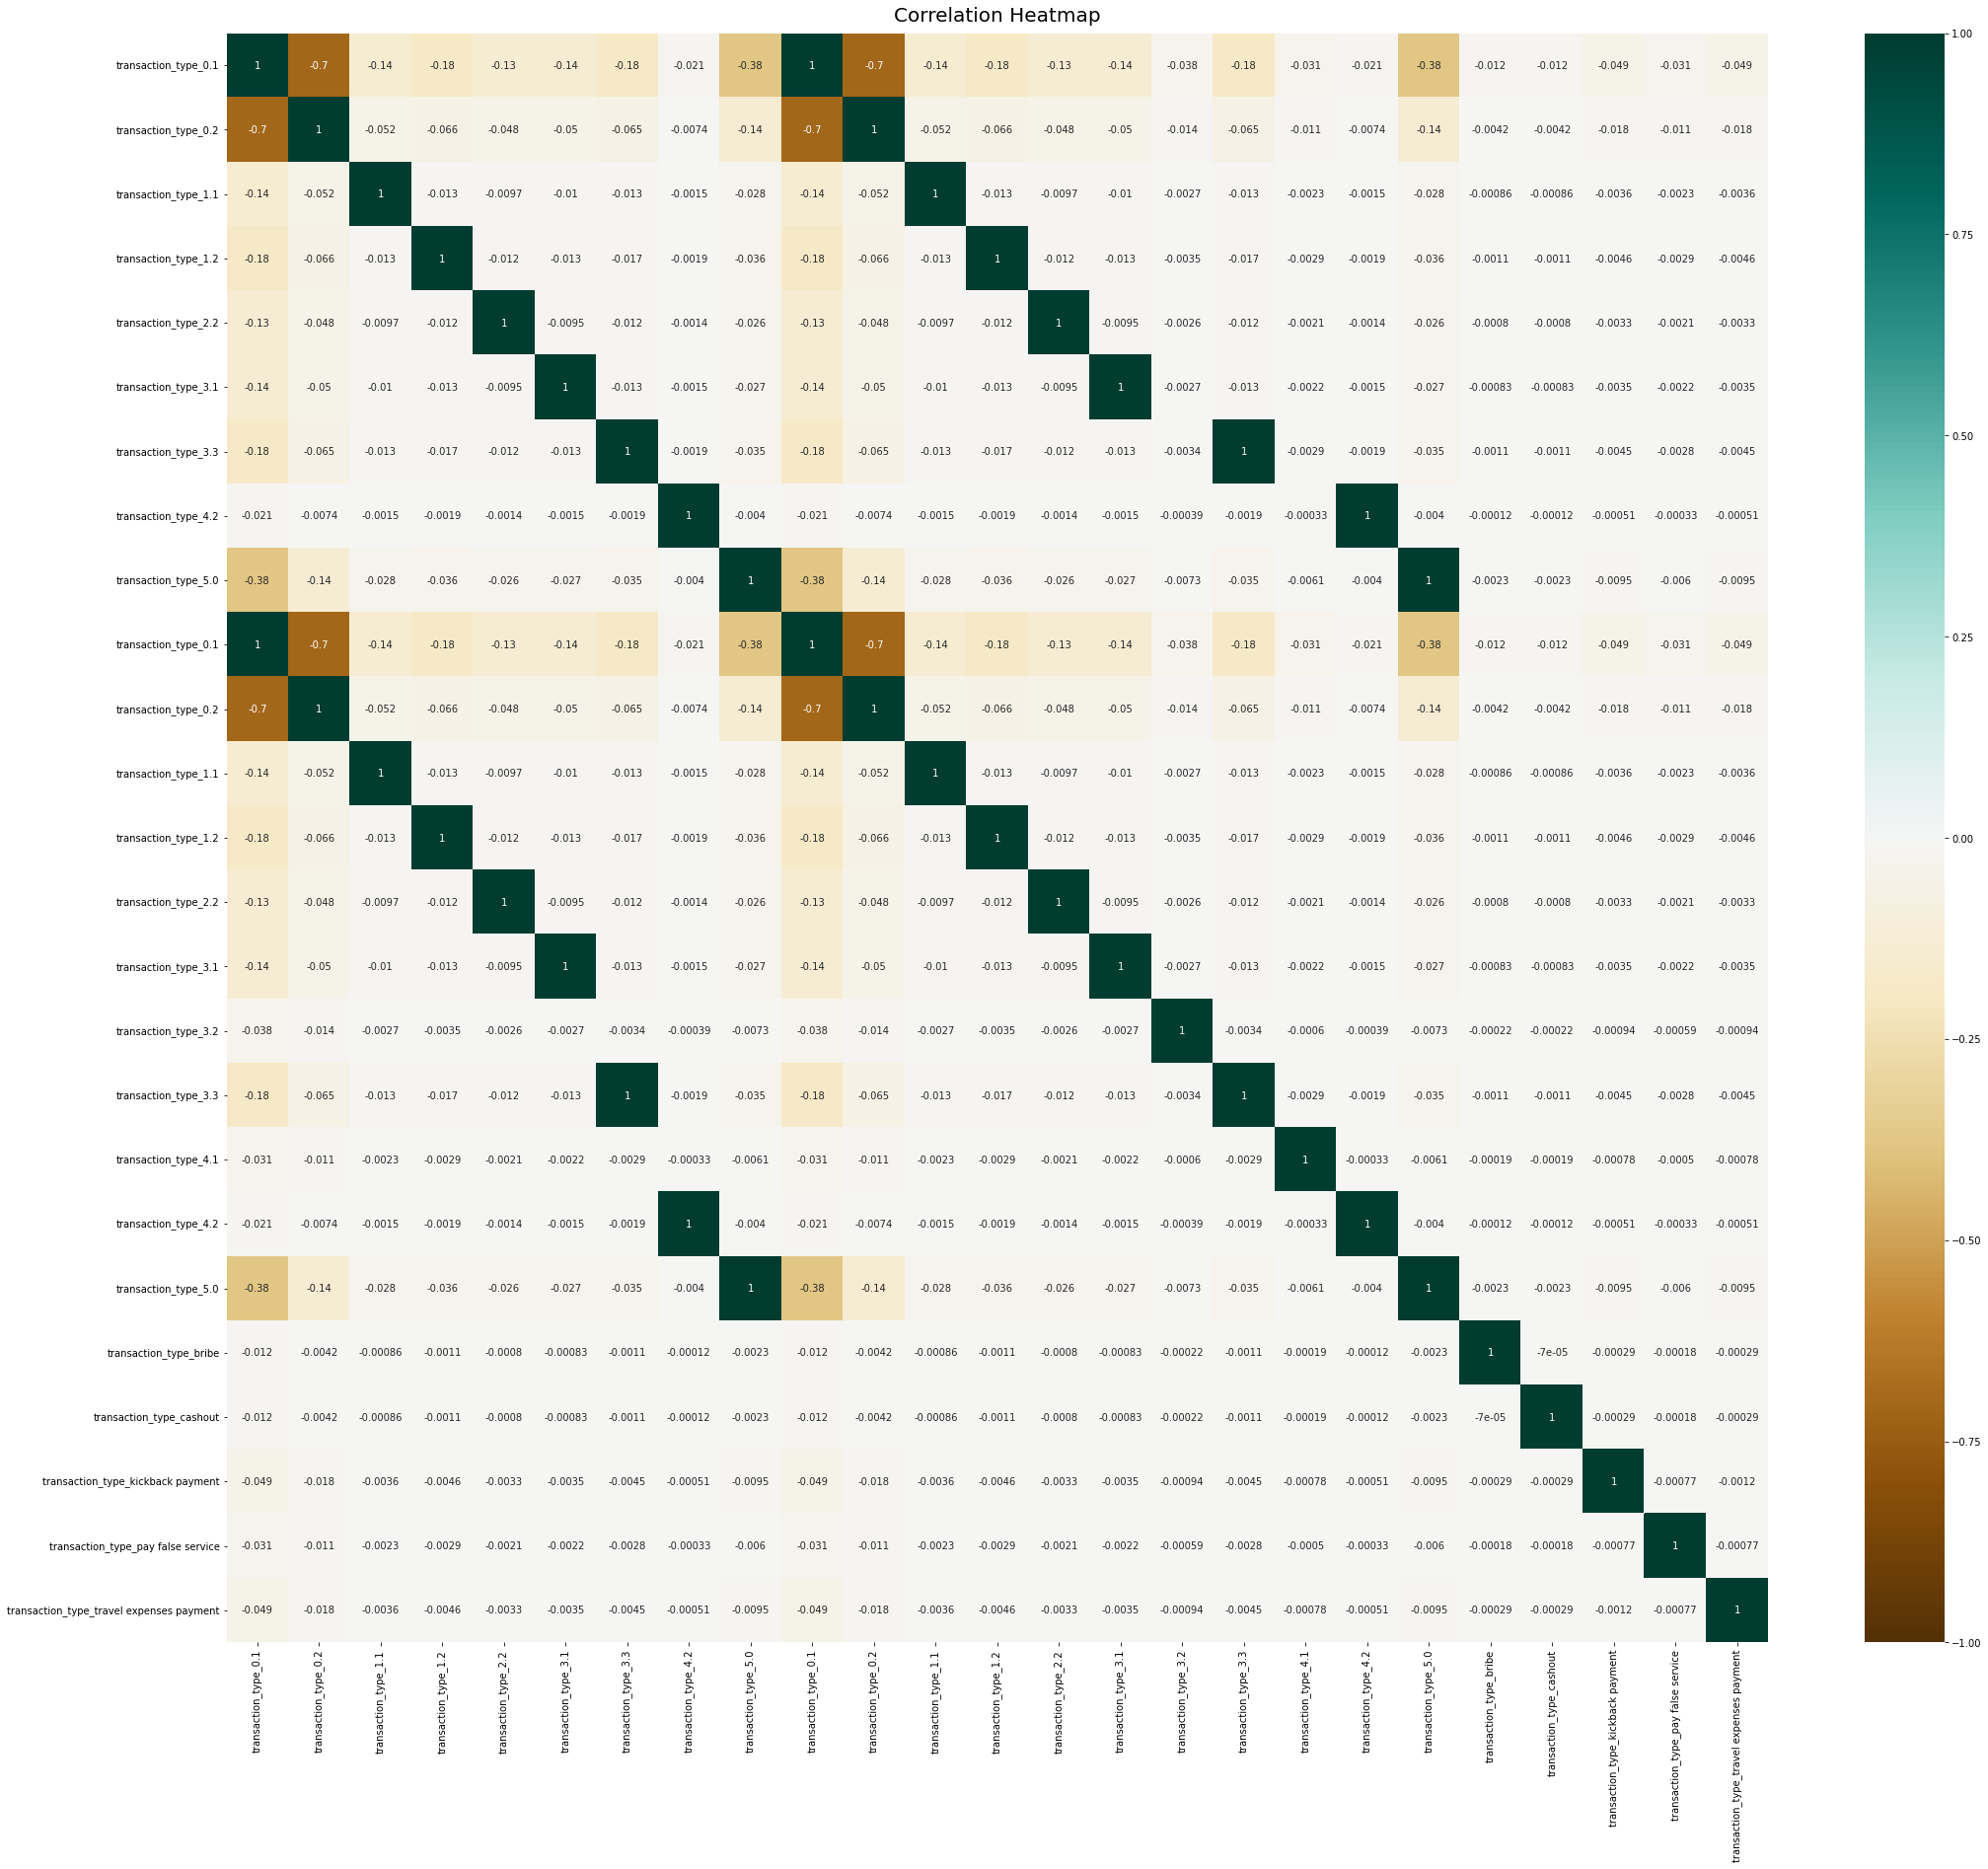

In [68]:
corr_data = transactions_one_hot[2][['transaction_type_0.1', 'transaction_type_0.2', 'transaction_type_1.1', 
                      'transaction_type_1.2', 'transaction_type_2.2', 'transaction_type_3.1', 
                      'transaction_type_3.3', 'transaction_type_4.2', 'transaction_type_5.0', 
                      'transaction_type_0.1', 'transaction_type_0.2', 'transaction_type_1.1', 
                      'transaction_type_1.2', 'transaction_type_2.2', 'transaction_type_3.1', 
                      'transaction_type_3.2', 'transaction_type_3.3', 'transaction_type_4.1', 
                      'transaction_type_4.2', 'transaction_type_5.0', 'transaction_type_bribe', 
                      'transaction_type_cashout', 'transaction_type_kickback payment', 
                      'transaction_type_pay false service', 'transaction_type_travel expenses payment']]

plt.figure(figsize=(35, 30))
heatmap = sns.heatmap(corr_data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12);

# Data preparation

In [69]:
from sklearn import preprocessing

Transactions=[
              data.drop(columns=['account_from', 'account_to', 'currency', 'location','transaction_id','sender','receiver','date']) 
              for data in transactions_one_hot
              ]
Transactions=[data[data['flag'].notna()] for data in Transactions]

for data in Transactions:
  le = preprocessing.LabelEncoder()
  le.fit(data.flag)
  data['Flagged'] = le.transform(data.flag)

Transactions = [data.drop(columns=['flag']) for data in Transactions]

X=[data.iloc[:,0:-1] for data in Transactions]
y=[data.iloc[:,-1] for data in Transactions]

In [70]:
for label in y:
  print(label.value_counts())
  print('\n')

1    41977
0      785
Name: Flagged, dtype: int64


1    25582
0      510
Name: Flagged, dtype: int64


1    142776
0       440
Name: Flagged, dtype: int64




# Split train-test

In [71]:
def traintest(X, y, num=0.3):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num, random_state=42)
  return X_train, y_train, X_test, y_test

# Prediction

In [87]:
def prediction(model, X_test, y_test):
  y_fit=model.predict(X_test)
  report=classification_report(y_test,y_fit)
  return y_fit, report

# Classification Methods

## Suport Vector Machine

In [73]:
def svm(X_train, y_train, string='rbf', num=1E8):
  model = SVC(kernel=string, C=num)
  model.fit(X_train, y_train)
  return model

## Random forest classification

In [74]:
def rforest(X_train, y_train):
  tree = RandomForestClassifier().fit(X_train, y_train)
  return tree

# Balance Methods

## Undersampling

### Random Undersampling

In [75]:
def rundersampling(X, y, threshold=0.5):
  X=X.to_numpy()
  y=y.to_numpy()
  undersample = RandomUnderSampler(sampling_strategy=threshold)
  X_under , y_under=undersample.fit_resample(X, y)
  print("RANDOM UNDERSAMPLING")
  print("Original balance")
  print(Counter(y))
  print("Undersampled balance")
  print(Counter(y_under))
  print("\n")
  return X_under, y_under

### Near_Miss_1

In [93]:
def nearm1(X, y, n_neighbors=100):
  X=X.to_numpy()
  y=y.to_numpy()
  undersample = NearMiss(version=1, n_neighbors=3)
  X_under , y_under=undersample.fit_resample(X, y)
  print("NEAR MISS 1 UNDERSAMPLING")
  print("Original balance")
  print(Counter(y))
  print("Undersampled balance")
  print(Counter(y_under))
  print("\n")
  return X_under, y_under

### Tomek Links

In [77]:
def tomeklinks(X, y):
  X=X.to_numpy()
  y=y.to_numpy()
  undersample = TomekLinks()
  X_under , y_under=undersample.fit_resample(X, y)
  print("TOMEK LINKS UNDERSAMPLING")
  print("Original balance")
  print(Counter(y))
  print("Undersampled balance")
  print(Counter(y_under))
  print("\n")
  return X_under, y_under


## Oversampling

### Random Oversampling

In [79]:
def roversampling(X, y, threshold=0.3):
  X=X.to_numpy()
  y=y.to_numpy()
  oversample = RandomOverSampler(sampling_strategy=threshold)
  X_over , y_over=oversample.fit_resample(X, y)
  print("RANDOM OVERSAMPLING")
  print("Original balance")
  print(Counter(y))
  print("Oversampled balance")
  print(Counter(y_over))
  print("\n")
  return X_over, y_over

# Balance the data

In [80]:
def balancedata(methods, X, y):
  new_data = []
  for method in methods:
    X_new, y_new = method(X,y)
    new_data.append([X_new, y_new])
  return new_data

In [81]:
methods = [rundersampling, nearm1, roversampling]
num_methods = len(methods) + 1
methods_names= ['RAW','RANDOM UNDERSAMPLING', 'NEAR MISS 1 UNDERSAMPLING', 'RANDOM OVERSAMPLING']
balanced = []
count = 1
'''
for i,j in zip(X,y):
  print("######### DATA FRAME {} #########".format(count))
  b = balancedata(methods, i, j)
  balanced.append(b)
  count +=1
'''
balanced = balancedata(methods, X[2], y[2])

RANDOM UNDERSAMPLING
Original balance
Counter({1: 142776, 0: 440})
Undersampled balance
Counter({1: 880, 0: 440})


NEAR MISS 1 UNDERSAMPLING
Original balance
Counter({1: 142776, 0: 440})
Undersampled balance
Counter({0: 440, 1: 440})


RANDOM OVERSAMPLING
Original balance
Counter({1: 142776, 0: 440})
Oversampled balance
Counter({1: 142776, 0: 42832})




## Para mandar al otro equipo

In [ ]:
a = pd.DataFrame(balanced[0][0])
b = pd.DataFrame(balanced[0][1])

data_undersampling = pd.concat([a,b], axis=1, ignore_index=True)

a = pd.DataFrame(balanced[2][0])
b = pd.DataFrame(balanced[2][1])

data_oversampling = pd.concat([a,b], axis=1, ignore_index=True)

data_names = ['X{}'.format(i) for i in range(24)]
data_names.append('y')

data_undersampling.columns = data_names
data_oversampling.columns = data_names

data_undersampling.to_csv('Datos_undersampling.csv')
data_undersampling.to_csv('Datos_oversampling.csv')


# Carry on classification on balanced data

## Load premodified models


In [97]:
# LOAD THE MODELS
svm_models = []
for i in range(num_methods):
  filename = "svm_model with Sim1 as training{}.sav".format(i)
  loaded_model = pickle.load(open(filename, 'rb'))
  svm_models.append(loaded_model)

# Split data


In [98]:
#balanced_data = [traintest(X[0],y[0])]
balanced_data = []
for data in balanced:
  #X_train, y_train, X_test, y_test = traintest(data[0],data[1])
  X_train, y_train, X_test, y_test = data[0], data[1], X[0], y[0]
  balanced_data.append([X_train, y_train, X_test, y_test])

## Support vector machine

In [ ]:
svm_models = [svm(X[2], y[2])]
for data in balanced_data:
  svm_models.append(svm(data[0],data[1]))

In [99]:
predictions=[]
for i in range(len(svm_models)):
  predictions.append(prediction(svm_models[i],balanced_data[0][2],balanced_data[0][3]))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [100]:
for pred,name in zip(predictions,methods_names):
  print(name)
  print(pred[1])
  print('\n')

RAW
              precision    recall  f1-score   support

           0       1.00      0.55      0.71       785
           1       0.99      1.00      1.00     41977

    accuracy                           0.99     42762
   macro avg       1.00      0.78      0.85     42762
weighted avg       0.99      0.99      0.99     42762



RANDOM UNDERSAMPLING
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       785
           1       1.00      1.00      1.00     41977

    accuracy                           1.00     42762
   macro avg       0.99      1.00      0.99     42762
weighted avg       1.00      1.00      1.00     42762



NEAR MISS 1 UNDERSAMPLING
              precision    recall  f1-score   support

           0       0.56      1.00      0.72       785
           1       1.00      0.99      0.99     41977

    accuracy                           0.99     42762
   macro avg       0.78      0.99      0.85     42762
weighted avg       

## Save Models


In [ ]:
# SAVE THE MODELS
for i in range(len(svm_models)):
  filename = "svm_model with Sim1 as training{}.sav".format(i)
  pickle.dump(svm_models[i], open(filename, 'wb'))

#Random Forest


In [ ]:
ran_models = [rforest(X[2], y[2])]
for data in balanced_data:
  ran_models.append(rforest(data[0],data[1]))

In [ ]:
predictions1=[]
for i in range(len(ran_models)):
  predictions1.append(prediction(ran_models[i],balanced_data[0][2],balanced_data[0][3]))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- transaction_type_5
Feature names seen at fit time, yet now missing:
- transaction_type_5.0

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {se

In [ ]:
for pred,name in zip(predictions1,methods_names):
  print(name)
  print(pred[1])
  print('\n')

RAW
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       785
           1       1.00      1.00      1.00     41977

    accuracy                           1.00     42762
   macro avg       1.00      1.00      1.00     42762
weighted avg       1.00      1.00      1.00     42762



RANDOM UNDERSAMPLING
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       785
           1       1.00      1.00      1.00     41977

    accuracy                           1.00     42762
   macro avg       0.99      1.00      0.99     42762
weighted avg       1.00      1.00      1.00     42762



NEAR MISS 1 UNDERSAMPLING
              precision    recall  f1-score   support

           0       0.04      1.00      0.07       785
           1       1.00      0.50      0.66     41977

    accuracy                           0.50     42762
   macro avg       0.52      0.75      0.37     42762
weighted avg       

# Confusion Matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- transaction_type_5
Feature names seen at fit time, yet now missing:
- transaction_type_5.0

  warnings.warn(message, FutureWarning)


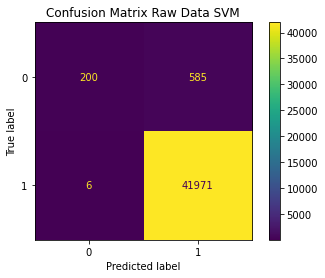

In [ ]:
y_true_raw=y[0]
y_pred_raw=predictions[0][0]

plot_confusion_matrix(svm_models[0],balanced_data[0][2], y_true_raw) 
plt.title("Confusion Matrix Raw Data SVM")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


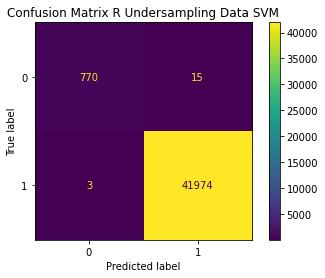

In [ ]:
y_true_raw=y[0]
y_pred_raw=predictions[0][0]

plot_confusion_matrix(svm_models[1],balanced_data[0][2], y_true_raw) 
plt.title("Confusion Matrix R Undersampling Data SVM")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


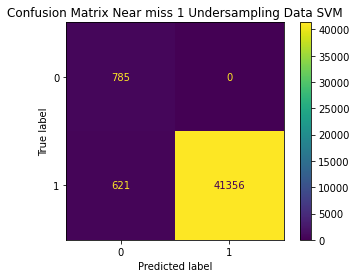

In [101]:
y_true_raw=y[0]
y_pred_raw=predictions[0][0]

C=confusion_matrix(y_true_raw, y_pred_raw)
plot_confusion_matrix(svm_models[2],balanced_data[0][2], y_true_raw) 
plt.title("Confusion Matrix Near miss 1 Undersampling Data SVM")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


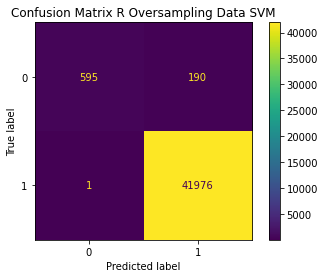

In [ ]:
y_true_raw=y[0]
y_pred_raw=predictions[0][0]

C=confusion_matrix(y_true_raw, y_pred_raw)
plot_confusion_matrix(svm_models[3],balanced_data[0][2], y_true_raw) 
plt.title("Confusion Matrix R Oversampling Data SVM")
plt.show()

In [ ]:
C2 / C2.astype(np.float).sum(axis=1)

# Roc-AUC


In [ ]:
Roc_Raw=roc_auc_score(y[0], svm_models[0].decision_function(X[0]))
Roc_Under=roc_auc_score(y[0], svm_models[1].decision_function(X[0]))
Roc_Near=roc_auc_score(y[0], svm_models[2].decision_function(X[0]))
Roc_Over=roc_auc_score(y[0], svm_models[3].decision_function(X[0]))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- transaction_type_5
Feature names seen at fit time, yet now missing:
- transaction_type_5.0

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
print("Roc-AUC SVM with Raw:")
print(Roc_Raw)
print("\n"+"Roc-AUC SVM with RUndesample:")
print(Roc_Under)
print("\n"+"Roc-AUC SVM with Near-Miss 1 Undersample:")
print(Roc_Near)
print("\n"+"Roc-AUC SVM with ROversample:")
print(Roc_Over)

Roc-AUC SVM with Raw:
0.9799661598124176

Roc-AUC SVM with RUndesample:
0.9950804421408205

Roc-AUC SVM with Near-Miss 1 Undersample:
0.49143683324307563

Roc-AUC SVM with ROversample:
0.9999634315971334


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- transaction_type_5
Feature names seen at fit time, yet now missing:
- transaction_type_5.0

  warnings.warn(message, FutureWarning)


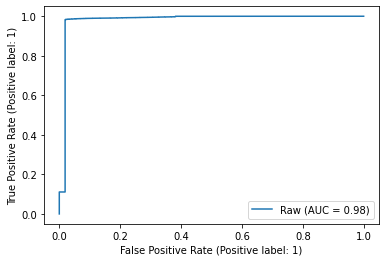

In [ ]:
metrics.plot_roc_curve(svm_models[0], X[0], y[0],name="Raw")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


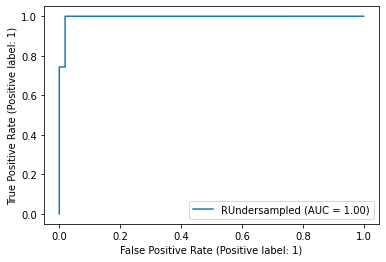

In [ ]:
metrics.plot_roc_curve(svm_models[1], X[0], y[0],name="RUndersampled")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


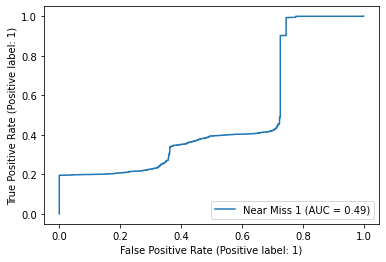

In [ ]:
metrics.plot_roc_curve(svm_models[2], X[0], y[0],name="Near Miss 1")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


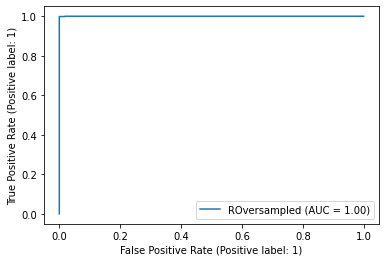

In [ ]:
metrics.plot_roc_curve(svm_models[3], X[0], y[0],name="ROversampled")

In [ ]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [ ]:
model = SVC(kernel='rbf', C=1E8)
plot_learning_curve(model,"Curva de aprendizaje SVM RAW",X[0],y[0])

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

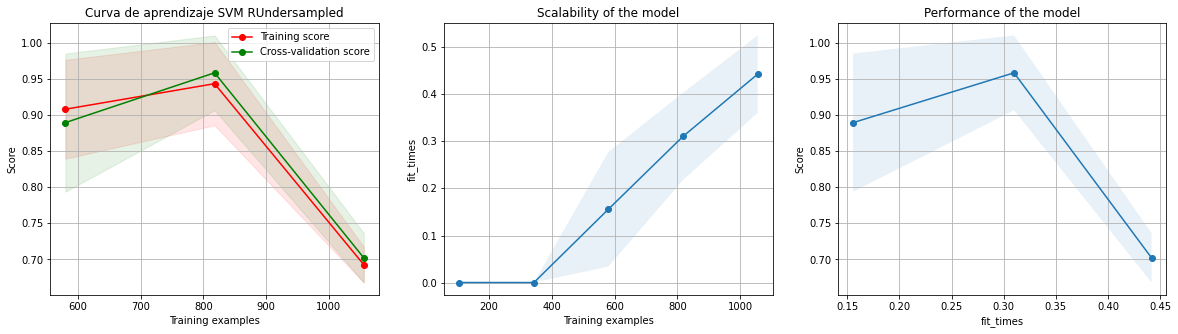

In [ ]:
model = SVC(kernel='rbf', C=1E8)
plot_learning_curve(model,"Curva de aprendizaje SVM RUndersampled",balanced_data[0][0],balanced_data[0][1])

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

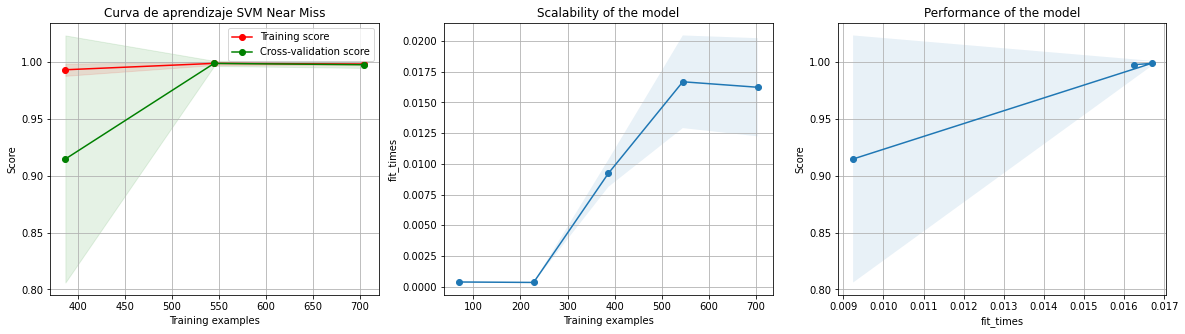

In [ ]:
plot_learning_curve(model,"Curva de aprendizaje SVM Near Miss",balanced_data[1][0],balanced_data[1][1])

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

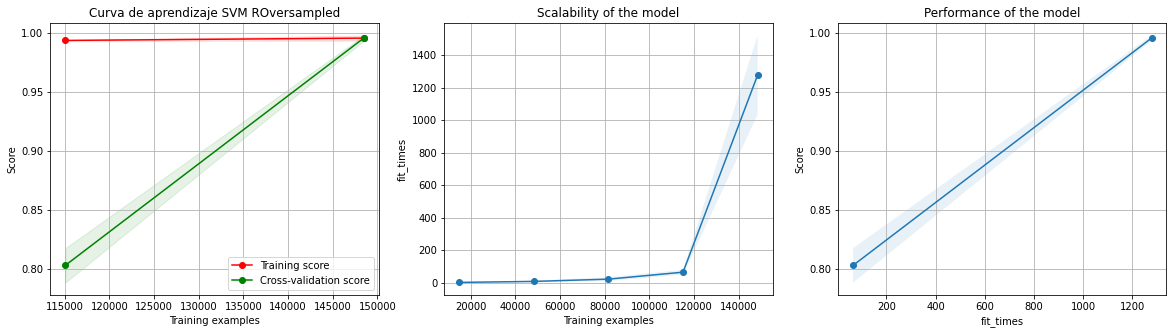

In [ ]:
plot_learning_curve(model,"Curva de aprendizaje SVM ROversampled",balanced_data[2][0],balanced_data[2][1])